In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [2]:
crash = pd.read_csv('../DS-Unit-2-4-Build-Week/crash.csv')

Create categorical month and hour features from a date/time feature:

In [3]:
def crashmo(date):
    return date[:2]

crash['MONTH'] = crash['CRASH_DATE'].apply(crashmo)

In [4]:
def crashhr(date):
    
    hour = date[11:13]
    
    if date[20] == 'A':
        
        if int(hour) == 12:
            return '00'

        return hour

    else:
        
        if int(hour) == 12:
            return hour
        
        return str(int(hour) + 12)

crash['HOUR'] = crash['CRASH_DATE'].apply(crashhr)

Clean outlier speed limits:

In [5]:
mode = crash['POSTED_SPEED_LIMIT'].mode()[0]

def speeds(speed):
    
    if speed == 99:
        
        return mode
    
    speed = 5 * (speed // 5)
    
    if speed == 0:
        
        return mode
    
    return speed

crash['POSTED_SPEED_LIMIT'] = crash['POSTED_SPEED_LIMIT'].apply(speeds)
crash['POSTED_SPEED_LIMIT'].value_counts()

30    272459
35     24424
25     21355
20     13603
15     12038
10      6901
5       3295
40      3233
45      2127
55       335
50        72
60        23
65         7
70         2
Name: POSTED_SPEED_LIMIT, dtype: int64

Assign features and target, then review data:

In [6]:
features = ['MONTH', 'HOUR', 'TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 
            'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 
            'POSTED_SPEED_LIMIT']
target = 'MOST_SEVERE_INJURY'

In [7]:
crash[features].describe().T

,count,mean,std,min,25%,50%,75%,max
POSTED_SPEED_LIMIT,359874.0,28.759052,5.414784,5.0,30.0,30.0,30.0,70.0


In [8]:
crash[features].describe(include = object).T

,count,unique,top,freq
MONTH,359874,12,10,38018
HOUR,359874,24,16,27620
TRAFFIC_CONTROL_DEVICE,359874,19,NO CONTROLS,207376
WEATHER_CONDITION,359874,11,CLEAR,284503
LIGHTING_CONDITION,359874,6,DAYLIGHT,238671
FIRST_CRASH_TYPE,359874,18,REAR END,89457
TRAFFICWAY_TYPE,359874,20,NOT DIVIDED,163870
ALIGNMENT,359874,6,STRAIGHT AND LEVEL,350942
ROADWAY_SURFACE_COND,359874,7,DRY,269420
ROAD_DEFECT,359874,7,NO DEFECTS,300262


Remove observations without the target class and view the distribution:

In [9]:
crash[target].isnull().sum()

2004

In [10]:
crash = crash.dropna(subset=[target])

In [11]:
crash[target].value_counts(normalize = True)

NO INDICATION OF INJURY     0.879476
NONINCAPACITATING INJURY    0.065795
REPORTED, NOT EVIDENT       0.038872
INCAPACITATING INJURY       0.015039
FATAL                       0.000819
Name: MOST_SEVERE_INJURY, dtype: float64

In [12]:
crash[target].value_counts()

NO INDICATION OF INJURY     314738
NONINCAPACITATING INJURY     23546
REPORTED, NOT EVIDENT        13911
INCAPACITATING INJURY         5382
FATAL                          293
Name: MOST_SEVERE_INJURY, dtype: int64

Separate data into train and test sets:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(crash[features], crash[target], test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((286296, 12), (71574, 12), (286296,), (71574,))

Evaluate baseline with a dummy classifier:

In [14]:
pipeline0 = make_pipeline(
    ce.OrdinalEncoder(),
    DummyClassifier()
)

In [15]:
pipeline0.fit(X_train, y_train)
y_pred = pipeline0.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        70
   INCAPACITATING INJURY       0.02      0.02      0.02      1060
 NO INDICATION OF INJURY       0.88      0.88      0.88     62901
NONINCAPACITATING INJURY       0.07      0.07      0.07      4681
   REPORTED, NOT EVIDENT       0.04      0.04      0.04      2862

                accuracy                           0.78     71574
               macro avg       0.20      0.20      0.20     71574
            weighted avg       0.78      0.78      0.78     71574



In [16]:
pd.Series(y_pred).value_counts()

NO INDICATION OF INJURY     62925
NONINCAPACITATING INJURY     4701
REPORTED, NOT EVIDENT        2816
INCAPACITATING INJURY        1080
FATAL                          52
dtype: int64

Resample the heavily weighted data (train set only) for improved modelling:

In [17]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

X_train, y_train = rus.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((1115, 12), (1115,))

Match the resampled data with the format of the test data (necessary to make a prediction). 
Then confirm the samples are balanced by class label:

In [18]:
X_train = pd.DataFrame(X_train, columns = features)
y_train = pd.Series(y_train, name = target)

y_train.value_counts()

NONINCAPACITATING INJURY    223
REPORTED, NOT EVIDENT       223
FATAL                       223
INCAPACITATING INJURY       223
NO INDICATION OF INJURY     223
Name: MOST_SEVERE_INJURY, dtype: int64

Model, predict, and evaluate the data with Logistic Regression:

In [19]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression(class_weight = 'balanced', multi_class = 'auto')
)

In [20]:
param_distributions = {
    'logisticregression__penalty': ['l1', 'l2'], 
    'logisticregression__C': [.1, 1, 10]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_distributions, 
    n_iter = 10, 
    cv = 3, 
    scoring = make_scorer(recall_score, average = 'macro', 
                          labels = ['NONINCAPACITATING INJURY', 'INCAPACITATING INJURY', 'FATAL']),
    verbose = 10, 
    return_train_score = True, 
    n_jobs = -2
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done   7 out of  18 | elapsed:    2.4s remaining:    3.9s
[Parallel(n_jobs=-2)]: Done   9 out of  18 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done  11 out of  18 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done  13 out of  18 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done  15 out of  18 | elapsed:    2.7s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:    2.7s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('logisticregression',
                                              LogisticRegression(C=1.0,
                                                                 class_weight='balanced',
                                              

In [21]:
print(search.best_params_)
print(search.best_score_)

{'logisticregression__penalty': 'l1', 'logisticregression__C': 10}
0.28101644245142005


In [22]:
model = search.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

                   FATAL       0.00      0.49      0.00        70
   INCAPACITATING INJURY       0.02      0.14      0.04      1060
 NO INDICATION OF INJURY       0.91      0.25      0.39     62901
NONINCAPACITATING INJURY       0.08      0.15      0.11      4681
   REPORTED, NOT EVIDENT       0.05      0.35      0.09      2862

                accuracy                           0.25     71574
               macro avg       0.21      0.27      0.13     71574
            weighted avg       0.81      0.25      0.36     71574



In [23]:
pd.Series(y_pred).value_counts()

REPORTED, NOT EVIDENT       19932
FATAL                       18977
NO INDICATION OF INJURY     17170
NONINCAPACITATING INJURY     8437
INCAPACITATING INJURY        7058
dtype: int64

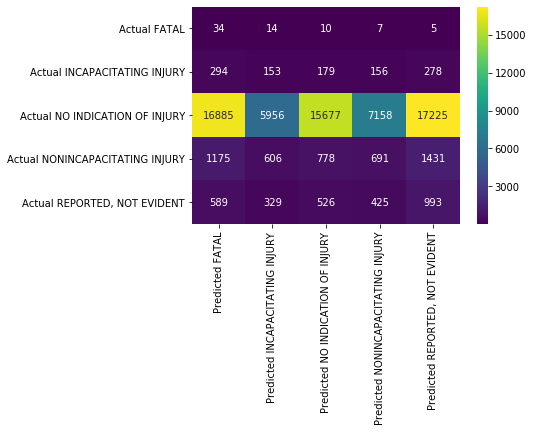

In [24]:
def plot_confusion_matrix(y_test, y_pred):
    labels = unique_labels(y_test)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

Model, predict, and evaluate the data with Random Forest Classifier:

In [25]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier()
)

In [26]:
from scipy.stats import uniform

param_distributions = {
    'randomforestclassifier__n_estimators': range(64, 256), 
    'randomforestclassifier__max_depth': [4, 8, 16, 32], 
    'randomforestclassifier__max_features': uniform(0, 1), 
    'randomforestclassifier__min_samples_leaf': [1, 2, 4, 8], 
}

search = RandomizedSearchCV(
    pipeline2, 
    param_distributions = param_distributions, 
    n_iter = 10, 
    cv = 3, 
    scoring = make_scorer(recall_score, average = 'macro', 
                          labels = ['NONINCAPACITATING INJURY', 'INCAPACITATING INJURY', 'FATAL']),
    verbose = 10, 
    return_train_score = True, 
    n_jobs = -2
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  21 out of  30 | elapsed:    1.9s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done  25 out of  30 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:    2.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                               

In [27]:
print(search.best_params_)
print(search.best_score_)

{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 0.48962153483472626, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 81}
0.3288490284005979


In [28]:
model = search.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

                   FATAL       0.01      0.67      0.01        70
   INCAPACITATING INJURY       0.05      0.25      0.08      1060
 NO INDICATION OF INJURY       0.95      0.50      0.65     62901
NONINCAPACITATING INJURY       0.12      0.22      0.16      4681
   REPORTED, NOT EVIDENT       0.05      0.33      0.09      2862

                accuracy                           0.47     71574
               macro avg       0.24      0.39      0.20     71574
            weighted avg       0.84      0.47      0.59     71574



In [29]:
pd.Series(y_pred).value_counts()

NO INDICATION OF INJURY     32943
REPORTED, NOT EVIDENT       17176
NONINCAPACITATING INJURY     8479
FATAL                        7523
INCAPACITATING INJURY        5453
dtype: int64

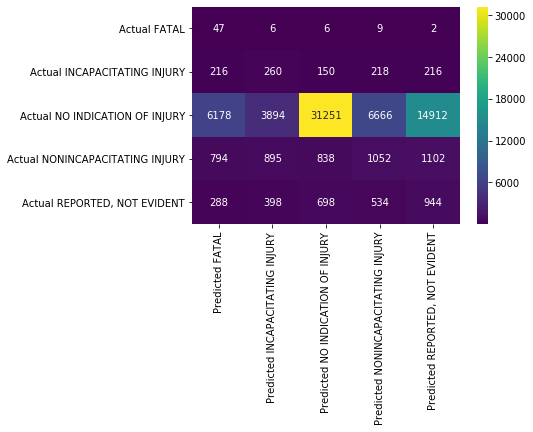

In [30]:
def plot_confusion_matrix(y_test, y_pred):
    labels = unique_labels(y_test)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

Evaluate permutation importance:

In [31]:
preprocessor = ce.OrdinalEncoder()
X_train_transformed = preprocessor.fit_transform(X_train[features])

model = search.best_estimator_
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(model, 
                                 make_scorer(recall_score, average = 'macro', 
                                             labels = ['NONINCAPACITATING INJURY', 'INCAPACITATING INJURY', 'FATAL']), 
                                 n_iter = 10, 
                                 cv = 'prefit')
permuter.fit(X_train_transformed, y_train)

eli5.show_weights(permuter, top=None, feature_names=features)

Weight,Feature
0.0019 ± 0.0055,POSTED_SPEED_LIMIT
0 ± 0.0000,PRIM_CONTRIBUTORY_CAUSE
0 ± 0.0000,ROAD_DEFECT
0 ± 0.0000,ROADWAY_SURFACE_COND
0 ± 0.0000,ALIGNMENT
0 ± 0.0000,TRAFFICWAY_TYPE
0 ± 0.0000,FIRST_CRASH_TYPE
0 ± 0.0000,LIGHTING_CONDITION
0 ± 0.0000,WEATHER_CONDITION
0 ± 0.0000,TRAFFIC_CONTROL_DEVICE
